<a href="https://colab.research.google.com/github/DavidJimenez10/CV-Deep-Learning/blob/main/Clasificacion_segun_ojos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificación del género de una persona según sus ojos**

Se obtuvo una [dataset](https://www.kaggle.com/datasets/pavelbiz/eyes-rtte?datasetId=1438879&sortBy=voteCount) con 11525 imágenes de ojos, clasificadas según el género de la persona.

## **Importando librerias**

In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import seaborn as sns
import random
import cv2

#Modelos
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

#Preprocesado
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Modelos y Evaluacion
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


#Capas
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D,MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils

## **Cargando datos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir '/content/dataset'

mkdir: cannot create directory ‘/content/dataset’: File exists


In [ ]:
!unzip -q '/content/drive/MyDrive/Datos_ojos/archive.zip' -d '/content/dataset'

replace /content/dataset/femaleeyes/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Obteniendo imagenes
paths_hom = ["/content/dataset/maleeyes/"+ path for path in os.listdir('/content/dataset/maleeyes')]
paths_muj = ["/content/dataset/femaleeyes/"+ path for path in os.listdir('/content/dataset/femaleeyes')]
print(paths_hom)
print(paths_muj)

paths_ojos = []
paths_ojos.extend(paths_muj)
paths_ojos.extend(paths_hom)
random.shuffle(paths_ojos)


['/content/dataset/maleeyes/6908.jpg', '/content/dataset/maleeyes/5341.jpg', '/content/dataset/maleeyes/856.jpg', '/content/dataset/maleeyes/2474.jpg', '/content/dataset/maleeyes/260.jpg', '/content/dataset/maleeyes/2882.jpg', '/content/dataset/maleeyes/1579.jpg', '/content/dataset/maleeyes/5499.jpg', '/content/dataset/maleeyes/6768.jpg', '/content/dataset/maleeyes/5564.jpg', '/content/dataset/maleeyes/582.jpg', '/content/dataset/maleeyes/2750.jpg', '/content/dataset/maleeyes/6637.jpg', '/content/dataset/maleeyes/268.jpg', '/content/dataset/maleeyes/7172.jpg', '/content/dataset/maleeyes/753.jpg', '/content/dataset/maleeyes/1846.jpg', '/content/dataset/maleeyes/1959.jpg', '/content/dataset/maleeyes/4599.jpg', '/content/dataset/maleeyes/6406.jpg', '/content/dataset/maleeyes/142.jpg', '/content/dataset/maleeyes/48.jpg', '/content/dataset/maleeyes/6819.jpg', '/content/dataset/maleeyes/20.jpg', '/content/dataset/maleeyes/4983.jpg', '/content/dataset/maleeyes/6099.jpg', '/content/dataset/mal

## **Explorando datos**

In [ ]:
#Encoding de las clases
fnames_train = np.array(paths_ojos)
labels_train = np.array([(0 if 'femaleeyes' in fname else 1) for fname in fnames_train])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Mujeres y Hombres')

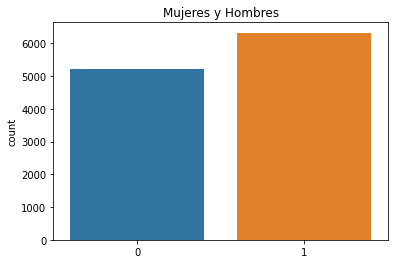

In [ ]:
sns.countplot(labels_train)
plt.title('Mujeres y Hombres')

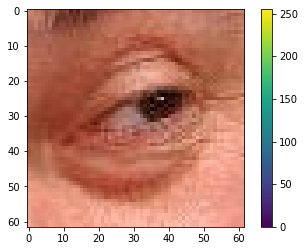

In [ ]:
img = plt.imread(fnames_train[0])
plt.imshow(img)
plt.grid(False)
plt.colorbar()

In [ ]:
img.shape

(62, 62, 3)

In [ ]:
def read_image(file_path, ROWS = 64,COLS = 64):
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  return cv2.resize(img, (ROWS, COLS))

In [ ]:
def prep_data(images, ROWS = 64,COLS = 64,CHANNELS=3):
  count = len(images)
  data = np.ndarray((count, ROWS, COLS, CHANNELS))
  for i, image_file in enumerate(images):
    image = read_image(image_file,ROWS,COLS)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data[i] = image   
  return data

In [ ]:
ROWS = 64
COLS = 64
CHANNELS = 3
train = prep_data(fnames_train,ROWS=ROWS,COLS=COLS)

In [ ]:
train=train/255.0

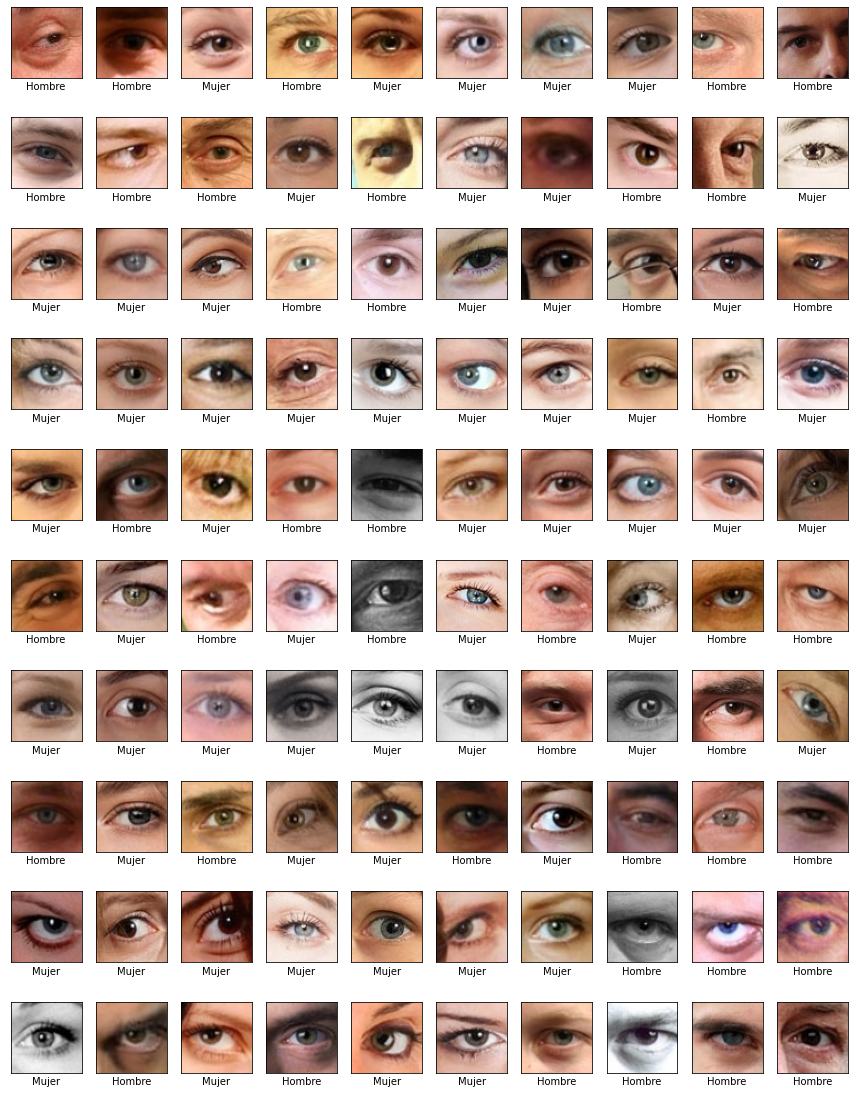

In [ ]:
plt.figure(figsize=(15,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i])
    plt.xlabel('Mujer' if labels_train[i]==0 else 'Hombre')
plt.show()

## **Extractores de características**Para las extracción de las características 

se utilizan 4 modelos, Resnet50, VGG16, VGG19 e InceptionV3. La clasificación se realizó utilizando los modelos de ML, Random Forest, Multi-Layer Perceptron y Support Vector Machine

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
batch_size = 64
train_it = datagen.flow_from_directory('/content/dataset',class_mode='binary',
                                       batch_size=batch_size,target_size=(224,224),subset='training', shuffle = False)

Found 11525 images belonging to 2 classes.


### Definición extractores de características

In [ ]:
def modelo_resnet50(train_it):
  base_model=ResNet50(include_top=False, pooling='max', weights='imagenet')
  #base_model.summary()

  for layer in base_model.layers:
    layer.trainable = False

  preds = base_model.predict(train_it)
  return (preds,train_it.labels)

def modelo_VGG16(train_it):
  basemodel=VGG16(include_top=False)
  #basemodel.summary()

  for layer in basemodel.layers:
    layer.trainable = False
  x = tf.keras.layers.GlobalMaxPool2D()(basemodel.output)
  #x = Flatten()(x)
  model = Model(inputs = basemodel.inputs, outputs = x)
  preds = model.predict(train_it)
  return (preds,train_it.labels)

def modelo_VGG19(train_it):
  base_model=VGG19(include_top=False, pooling='max', weights='imagenet')
  #base_model.summary()

  for layer in base_model.layers:
    layer.trainable = False
  x = Flatten()(base_model.output)
  model = Model(inputs = base_model.inputs, outputs = x)
  preds = model.predict(train_it)
  return (preds,train_it.labels)

def modelo_Inception3(train_it):
  base_model=InceptionV3(include_top=False, pooling='max', weights='imagenet',input_shape=(224,224,3))
  #base_model.summary()

  for layer in base_model.layers:
    layer.trainable = False

  preds = base_model.predict(train_it)
  return (preds,train_it.labels)     

### Definición función **modelos** (Estractor_Caracteristicas + ML + cross_validate)

In [ ]:
def modelos(x,y, modelo_extraccion):
  """
  Retorna dataframe con las metricas 'accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc' 
  para cada modelos y split de la validacion cruzada
  
  Args:
    x (numpy): caracteristicas del dataset
    y (numpy): etiquetas del dataset 
    modelo_extraccion (string): nombre del extractor de caracteristicas
  """
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
  models = [
          (modelo_extraccion+'-MLP',MLPClassifier()),
          (modelo_extraccion+'-RF', RandomForestClassifier()),
          (modelo_extraccion+'-SVM', SVC())]

  dfs = []
  results = []
  names = []
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
  target_names = ['Ojos_Mujer', 'Ojos_Hombre']
  for name, model in models:
    print(f'Entrenando modelo {name}')
    #Validacion cruzada
    kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #Guardando metricas
    results.append(cv_results)
    names.append(name)
    #Dataframe split
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)

  final = pd.concat(dfs, ignore_index=True)
  return final, models



### Modelos Resnet50 + ML

In [ ]:
x,y = modelo_resnet50(train_it)
final1, modelos_resnet50 = modelos(x,y,"resnet50")

Entrenando modelo resnet50-MLP
Entrenando modelo resnet50-RF
Entrenando modelo resnet50-SVM


### Modelos VGG16 + ML

In [ ]:
x,y = modelo_VGG16(train_it)
final2, modelos_VGG16 = modelos(x,y,"VGG16")

Entrenando modelo VGG16-MLP


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Entrenando modelo VGG16-RF
Entrenando modelo VGG16-SVM


### Modelos VGG19 + ML

In [ ]:
x,y = modelo_VGG19(train_it)
final3,modelos_VGG19= modelos(x,y, "VGG19")

Entrenando modelo VGG19-MLP


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Entrenando modelo VGG19-RF
Entrenando modelo VGG19-SVM


### Modelos InceptionV3 + ML

In [ ]:
x,y = modelo_Inception3(train_it)
final4, modelos_Inception3 = modelos(x,y, "Inception3")


Entrenando modelo Inception3-MLP


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Entrenando modelo Inception3-RF
Entrenando modelo Inception3-SVM


### Seleccionar Modelo

In [ ]:
final = pd.concat([final1,final2,final3,final4], axis=0)
#final = final1
final.reset_index(drop=True,inplace=True)
final.head()

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,37.593982,0.083994,0.777001,0.800889,0.777001,0.765975,0.885009,resnet50-MLP
1,35.706678,0.078846,0.804973,0.808324,0.804973,0.805335,0.892281,resnet50-MLP
2,37.829210,0.071923,0.783521,0.802502,0.783521,0.783847,0.883938,resnet50-MLP
3,5.894577,0.152265,0.738539,0.737425,0.738539,0.737444,0.820093,resnet50-RF
4,5.853453,0.152837,0.742424,0.742641,0.742424,0.740631,0.812267,resnet50-RF


In [ ]:
results_long = pd.melt(final,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time']
#Separar metricas rendimiento
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)]
results_long_nofit = results_long_nofit.sort_values(by='values')
#Separar metricas tiempo
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)]
results_long_fit = results_long_fit.sort_values(by='values')

### Resumen Métricas 

Se extrajeron las métricas de rendimiento y tiempo para cada modelo, luego se agrupan por promedio y desviación 

Se ordenan de manera ascendente respecto a score_time  para la métricas tiempo y de manera descendente respecto a test_f1_weighted para las métricas de rendimiento

In [ ]:
metrics = list(set(results_long_nofit.metrics.values))
final.groupby(['model'])[metrics].agg([np.std, np.mean]).sort_values(by=[('test_f1_weighted', 'mean')],ascending=False)

test_accuracy           test_roc_auc            \
                         std      mean          std      mean   
model                                                           
Inception3-SVM      0.002527  0.881492     0.004024  0.949743   
Inception3-MLP      0.009396  0.872557     0.005300  0.946147   
VGG19-MLP           0.004091  0.857790     0.001227  0.930863   
VGG16-MLP           0.004452  0.852740     0.004891  0.928587   
VGG16-SVM           0.001237  0.850667     0.004374  0.923238   
VGG19-SVM           0.004935  0.844839     0.005562  0.921948   
Inception3-RF       0.002960  0.823728     0.006226  0.898626   
VGG16-RF            0.001956  0.821785     0.003767  0.901685   
VGG19-RF            0.004439  0.812330     0.004846  0.893094   
resnet50-MLP        0.014635  0.788498     0.004540  0.887076   
resnet50-RF         0.001981  0.740707     0.004089  0.815494   
resnet50-SVM        0.007505  0.627510     0.007021  0.718417   

               test_recall_weighted           test_precision_weighted  \
                                std      mean                     std   
model                                                                   
Inception3-SVM             0.002527  0.881492                0.003027   
Inception3-MLP             0.009396  0.872557                0.008857   
VGG19-MLP                  0.004091  0.857790                0.004659   
VGG16-MLP                  0.004452  0.852740                0.005256   
VGG16-SVM                  0.001237  0.850667                0.002181   
VGG19-SVM                  0.004935  0.844839                0.003480   
Inception3-RF              0.002960  0.823728                0.003939   
VGG16-RF                   0.001956  0.821785                0.002816   
VGG19-RF                   0.004439  0.812330                0.006792   
resnet50-MLP               0.014635  0.788498                0.003911   
resnet50-RF                0.001981  0.740707                0.002609   
resnet50-SVM               0.007505  0.627510                0.012557   

                         test_f1_weighted            
                    mean              std      mean  
model                                                
Inception3-SVM  0.882350         0.002445  0.880953  
Inception3-MLP  0.872885         0.009225  0.872508  
VGG19-MLP       0.858329         0.004154  0.857323  
VGG16-MLP       0.853073         0.004050  0.852202  
VGG16-SVM       0.851758         0.001161  0.849746  
VGG19-SVM       0.847596         0.005086  0.843317  
Inception3-RF   0.824766         0.003006  0.822478  
VGG16-RF        0.823431         0.001697  0.820258  
VGG19-RF        0.814162         0.004109  0.810632  
resnet50-MLP    0.803905         0.019707  0.785052  
resnet50-RF     0.740071         0.001609  0.739164  
resnet50-SVM    0.663305         0.013247  0.576721

In [ ]:
time_metrics = list(set(results_long_fit.metrics.values))
final.groupby(['model'])[time_metrics].agg([np.std, np.mean]).sort_values(by=[('score_time', 'mean')],ascending=True)

score_time             fit_time           
                      std       mean       std       mean
model                                                    
VGG16-MLP        0.001989   0.032872  0.917437  16.490885
VGG19-MLP        0.003133   0.033717  0.390191  17.122577
Inception3-MLP   0.003371   0.063627  5.791073  29.774485
resnet50-MLP     0.006057   0.078255  1.163500  37.043290
VGG19-RF         0.000373   0.126561  0.046336   5.905348
VGG16-RF         0.002179   0.131126  0.046742   5.432656
resnet50-RF      0.001882   0.153625  0.052840   5.845912
Inception3-RF    0.004152   0.157659  0.110061  16.617496
VGG16-SVM        0.090523   4.513848  0.044206   3.494822
VGG19-SVM        0.174849   4.772446  0.064967   3.444599
Inception3-SVM   0.598946  18.998655  0.233514  16.578596
resnet50-SVM     0.239211  41.673366  0.488499  32.138784

Se seleccionó el modelo **Inception3-SVM**, ya que obtuvo el mejor desempeño

In [ ]:
modelo_ML = modelos_Inception3[2][1]

### Evaluación modelo **Inception3-SVM**

In [ ]:
x,y = modelo_Inception3(train_it)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
y_pred = modelo_ML.predict(X_test)

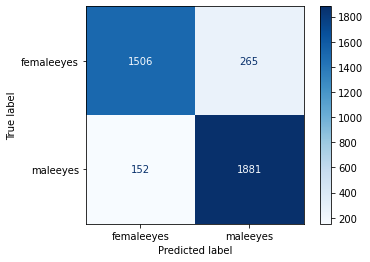

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm
train_it.class_indices
classes=list(train_it.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
accuracy = np.trace(cm) / float(np.sum(cm))
error = 1 - accuracy
print(accuracy, error)

0.8903785488958991 0.10962145110410093


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

  femaleeyes       0.91      0.85      0.88      1771
    maleeyes       0.88      0.93      0.90      2033

    accuracy                           0.89      3804
   macro avg       0.89      0.89      0.89      3804
weighted avg       0.89      0.89      0.89      3804



### Conclusión

El modelo clasifica mejor la clase mujeres, además se puede observar que el modelo para el caso de la clase mujer tiene una precisión mejor, pero su recall es más bajo, caso contrario a los hombres en el que la precisión es más baja, pero su recall es mejor.

## **Modelo Propio**

### Cargando datos

Se intentó hacer un aumento de datos para mejorar el aprendizaje del modelo, pero no se obtuvieron buenos resultados

In [ ]:
#datagen=ImageDataGenerator(rescale=1./255.,rotation_range=15,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,shear_range=10,zoom_range=[0.8,1.2],validation_split=0.25)
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)


In [ ]:
batch_size = 64
train_it = datagen.flow_from_directory('/content/dataset',class_mode='binary',
                                       batch_size=batch_size,target_size=(64,64),subset='training', shuffle = True)

Found 8069 images belonging to 2 classes.


In [ ]:
validation_it = datagen.flow_from_directory('/content/dataset',class_mode='binary',
                                       batch_size=batch_size,target_size=(64,64),subset='validation', shuffle = False)

Found 3456 images belonging to 2 classes.


In [ ]:
def plotImages(aug_iter,sub1=2,sub2=5, size=15):
  aug_images = [next(aug_iter)[0] for i in range(sub1*sub2)]
  fig, axes = plt.subplots(sub1, sub2, figsize=(size,size))
  axes = axes.flatten()
  for img, ax in zip(aug_images, axes):
    ax.imshow(img[0])
    ax.axis('off')
  plt.tight_layout()
  plt.show()

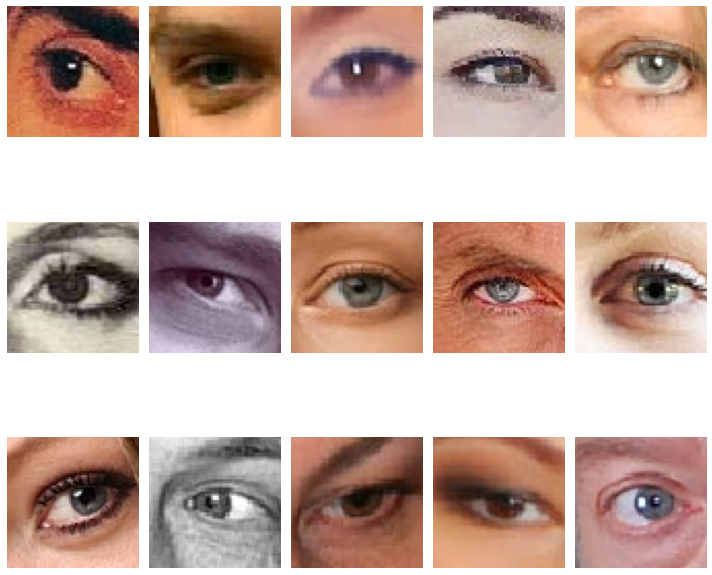

In [ ]:
plotImages(train_it, 3, 5, 10)

In [ ]:
def identity_block(input_tensor, filters, strides=1):
  """
  Retorna un bloque de capas con la estructura residual definida por resnet

  Arg:
  input_tensor (layer): capa anterior al bloque
  filters (tuple): contiene 3 filtros que se usaran en las capas convolucionales
  stride (int): paso o salto de la convolucion
  """
  f1, f2, f3 = filters

  x = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=strides)(input_tensor)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=strides, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)


  x = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=strides)(x)
  x = layers.BatchNormalization()(x)
  
  x = layers.Add()([x, input_tensor])
  output_tensor = layers.ReLU()(x)

  return output_tensor

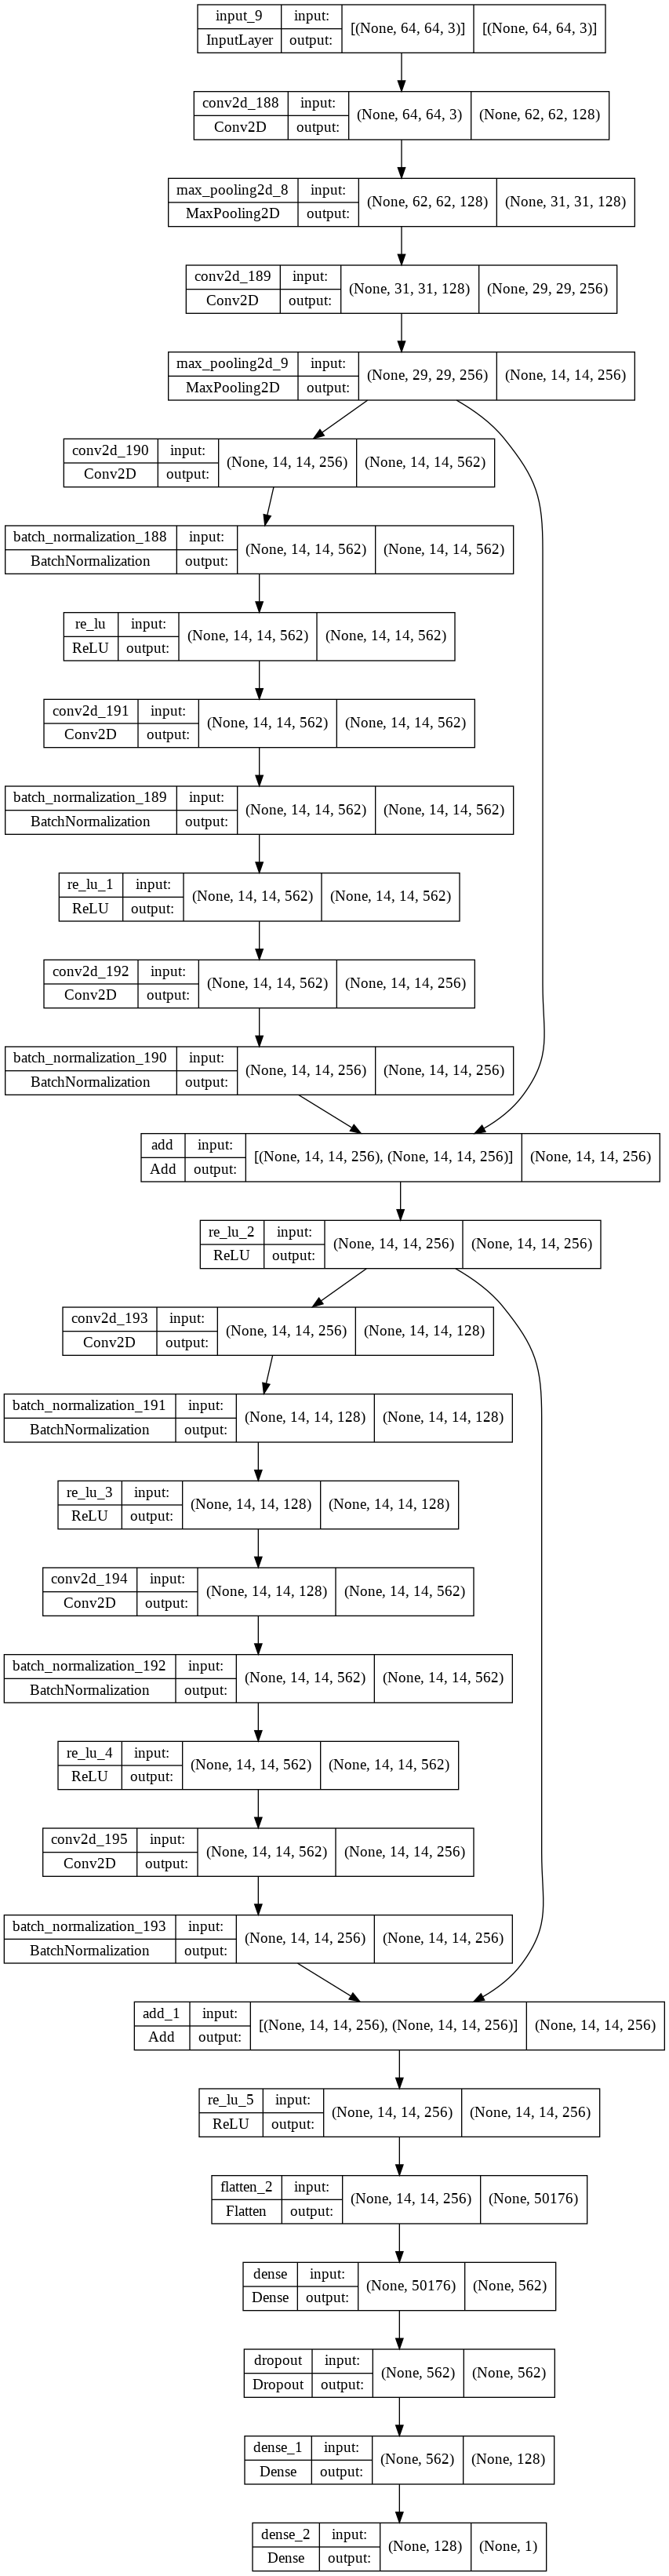

In [ ]:
input_shape=train.shape[1:4]
num_classes=2
#Input
input = keras.Input(shape=input_shape)
#Primeras capas convolucionales-maxpool
x = layers.Conv2D(128, 3, strides=1, activation = 'relu')(input)
x = layers.MaxPooling2D(pool_size = (2, 2))(x)
x = layers.Conv2D(256, 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = (2, 2))(x)
#Bloques residuales
for filters in [(562, 562, 256),(128, 562, 256)]:
  x = identity_block(x, filters)
#Capas clasificacion
x = layers.Flatten()(x)
x = layers.Dense(562, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
#Salida
output = layers.Dense(1, activation="sigmoid")(x)

model= keras.Model(input, output)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 62, 62, 128)  3584        ['input_9[0][0]']                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 31, 31, 128)  0          ['conv2d_188[0][0]']             
                                                                                                  
 conv2d_189 (Conv2D)            (None, 29, 29, 256)  295168      ['max_pooling2d_8[0][0]']        
                                                                                            

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("save_last_model.h5",save_best_only=True)]
history=model.fit(train_it, epochs=25, callbacks=callbacks, validation_data=validation_it)

Epoch 1/25
127/127 [==============================] - 19s 112ms/step - loss: 2.7798 - accuracy: 0.5322 - val_loss: 0.6916 - val_accuracy: 0.5486
Epoch 2/25
127/127 [==============================] - 13s 101ms/step - loss: 0.5700 - accuracy: 0.7281 - val_loss: 0.7589 - val_accuracy: 0.5498
Epoch 3/25
127/127 [==============================] - 12s 98ms/step - loss: 0.4235 - accuracy: 0.8194 - val_loss: 1.1344 - val_accuracy: 0.5486
Epoch 4/25
127/127 [==============================] - 14s 107ms/step - loss: 0.3660 - accuracy: 0.8435 - val_loss: 0.6611 - val_accuracy: 0.6586
Epoch 5/25
127/127 [==============================] - 13s 105ms/step - loss: 0.2922 - accuracy: 0.8820 - val_loss: 0.4125 - val_accuracy: 0.8064
Epoch 6/25
127/127 [==============================] - 13s 106ms/step - loss: 0.2688 - accuracy: 0.8881 - val_loss: 0.3336 - val_accuracy: 0.8487
Epoch 7/25
127/127 [==============================] - 13s 105ms/step - loss: 0.2472 - accuracy: 0.9007 - val_loss: 1.1276 - val_acc

### Evaluacion modelo propio

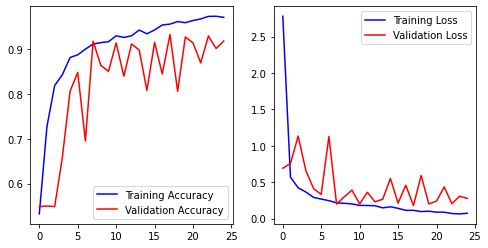

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
predictions=model.predict(validation_it)

In [ ]:
predictions_label=[0 if p<0.5 else 1 for p in predictions]

In [ ]:
train_it.class_indices

{'femaleeyes': 0, 'maleeyes': 1}

In [ ]:
labels_test=validation_it.labels
labels_test

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
data_val=validation_it.filepaths

Text(0.5, 0, 'Mujer  0 (Mujer)')

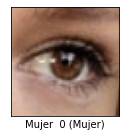

In [ ]:
index_image=10
plt.figure(figsize=(2,2))
plt.grid(False)
plt.xticks([])
plt.yticks([])
im=plt.imread(data_val[index_image])
plt.imshow(im)

predicted_label = "Mujer" if predictions[index_image][0]<0.5 else "Hombre"
real_label="Mujer" if labels_test[index_image]==0 else "Hombre"
plt.xlabel("{} {:2.0f} ({})".format(predicted_label,
                              predictions[index_image][0],
                              real_label))

In [ ]:
print(len(data_val))

3456


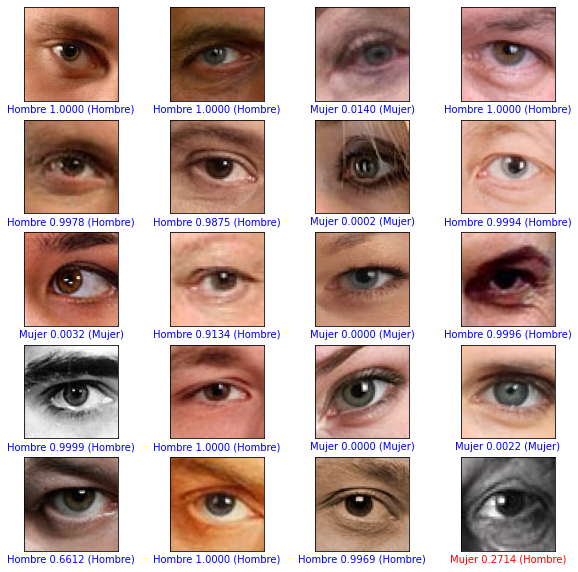

In [ ]:
import random
plt.figure(figsize=(10,10))
for index_image in range(20):
  int_r = random.randint(0,len(data_val))
  plt.subplot(5, 4, index_image+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  im=plt.imread(data_val[int_r])
  plt.imshow(im)

  predicted_label = "Mujer" if predictions[int_r][0]<0.5 else "Hombre"
  real_label="Mujer" if labels_test[int_r]==0 else "Hombre"
  color= 'blue' if predicted_label == real_label else 'red'
  plt.xlabel("{} {:2.0f} ({})".format(predicted_label,
                                predictions[int_r][0],
                                real_label))
  plt.xlabel(f'{predicted_label} {np.max(predictions[int_r][0]):.4f} ({real_label})', color=color)

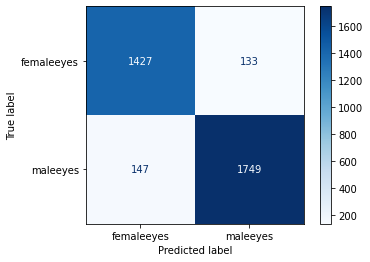

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_test, predictions_label)
cm
train_it.class_indices
classes=list(train_it.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
accuracy = np.trace(cm) / float(np.sum(cm))
error = 1 - accuracy
print(accuracy, error)


0.9189814814814815 0.08101851851851849


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(labels_test, predictions_label, target_names=classes))

              precision    recall  f1-score   support

  femaleeyes       0.91      0.91      0.91      1560
    maleeyes       0.93      0.92      0.93      1896

    accuracy                           0.92      3456
   macro avg       0.92      0.92      0.92      3456
weighted avg       0.92      0.92      0.92      3456



### Conclusión

El modelo en el que se implementó la arquitectura propia clasifica mejor que el modelo **Inception3-SVM**, se observa una mejora en la accuracy general, y en las métricas de f1-score y recall. Este modelo es más específico a la hora de clasificar que el anterior.